In [12]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import wget
import os
import matplotlib.pyplot as plt
import io

# Hyperparameters

In [2]:
vocab_size=10000
embedding=16
max_length=32
trunc='post'
padd='post'
oov_tok='<OOV>'
training_size=20000

# Getting the data

In [3]:
url='https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'
file='sarcasm.json'
sentences=[]
labels=[]
if os.path.exists('sarcasm.json')==False:
    wget.download(url,file)
else:
    #fill exist
    pass
with open(file,'r') as f:
    data=json.load(f)
for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

# Splitting the data

In [4]:
train_sentences=sentences[:training_size]
train_labels=labels[:training_size]
test_sentences=sentences[:training_size]
test_labels=labels[:training_size]

# Creating tokenizer, Sequences, and Padded Sequences

In [5]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index=tokenizer.word_index
training_sequence=tokenizer.texts_to_sequences(train_sentences)
training_padded=pad_sequences(training_sequence,maxlen=max_length,truncating=trunc,padding=padd)
testing_sequence=tokenizer.texts_to_sequences(test_sentences)
testing_padded=pad_sequences(testing_sequence,maxlen=max_length,truncating=trunc,padding=padd)

# Create Model

In [6]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 160,577
Trainable params: 160,577
Non-trainable params: 0
_________________________________________________________________


# Compile model

In [7]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

# Training the model

In [8]:
epochsN=20
history=model.fit(
    training_padded,
    train_labels,
    epochs=epochsN,
    validation_data=(testing_padded,test_labels),
    verbose=2)

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 - 2s - loss: 0.5459 - acc: 0.7143 - val_loss: 0.3309 - val_acc: 0.8737
Epoch 2/20
20000/20000 - 1s - loss: 0.2976 - acc: 0.8777 - val_loss: 0.2246 - val_acc: 0.9179
Epoch 3/20
20000/20000 - 1s - loss: 0.2233 - acc: 0.9126 - val_loss: 0.1712 - val_acc: 0.9398
Epoch 4/20
20000/20000 - 1s - loss: 0.1780 - acc: 0.9326 - val_loss: 0.1390 - val_acc: 0.9533
Epoch 5/20
20000/20000 - 2s - loss: 0.1482 - acc: 0.9456 - val_loss: 0.1147 - val_acc: 0.9617
Epoch 6/20
20000/20000 - 2s - loss: 0.1233 - acc: 0.9561 - val_loss: 0.0917 - val_acc: 0.9736
Epoch 7/20
20000/20000 - 2s - loss: 0.1065 - acc: 0.9625 - val_loss: 0.0763 - val_acc: 0.9772
Epoch 8/20
20000/20000 - 2s - loss: 0.0904 - acc: 0.9704 - val_loss: 0.0639 - val_acc: 0.9823
Epoch 9/20
20000/20000 - 2s - loss: 0.0784 - acc: 0.9742 - val_loss: 0.0540 - val_acc: 0.9854
Epoch 10/20
20000/20000 - 2s - loss: 0.0679 - acc: 0.9783 - val_loss: 0.0774 - val_acc: 0.9711
Epoch 11/

# Graphing the process

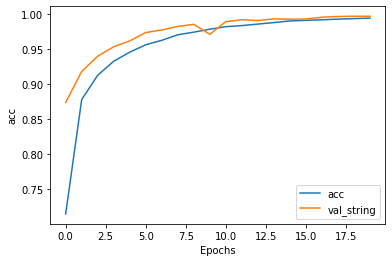

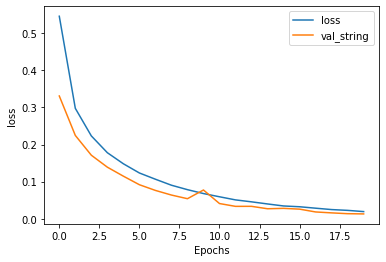

In [10]:
def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string,'val_string'])
    plt.show()
plot_graph(history,'acc')
plot_graph(history,'loss')

# Create the cluster

In [11]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [15]:
weights = model.layers[0].get_weights()[0]
out_v = io.open('Sarcasm_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('Sarcasm_meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()